# Handwritten Image Detection with Keras

- In this notebook, we will work with the MNIST dataset.
- This dataset contains 70,000 images of handwritten digits in grayscale (0=black, 255=white).
- The images are 28 pixels by 28 pixels for a total of 784 pixels.

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop, Adam, SGD
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


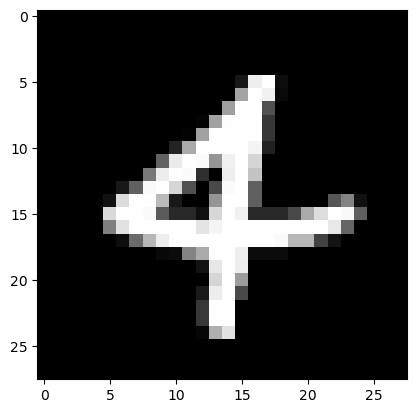

In [3]:
# Print a sample image
plt.imshow(X_train[150], cmap='Greys_r')
plt.show()

In [4]:
# Create binary class matrices using one-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Print a sample target vector: 4
print(y_train[150])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Part-1: MLP
- For the first part, we will use a basic NN arcitecture of MLP.
- We will flatten the images into 2D vectors and train a typical feed-forward model to classify handwritten digits.

In [5]:
# Flatten image vectors into inputs to be used in a feed-forward model
X_train_mlp = X_train.reshape(len(X_train), 28*28).astype('float32')
X_test_mlp = X_test.reshape(len(X_test), 28*28).astype('float32')

## Normalize the inputs to make them between 0 and 1
X_train_mlp /= 255
X_test_mlp /= 255

print(f"Train shape: {X_train_mlp.shape}")
print(f"Test shape: {X_test_mlp.shape}")

Train shape: (60000, 784)
Test shape: (10000, 784)


In [6]:
# Build an MLP model
mlp_model = Sequential([
    Dense(96, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Ten classes for MNIST digits: 0-9
])

# Compile the model
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model
history_mlp = mlp_model.fit(
    X_train_mlp, y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(X_test_mlp, y_test),
)

Epoch 1/20
938/938 [==============================] - 4s 3ms/step - loss: 0.4128 - accuracy: 0.8756 - val_loss: 0.1561 - val_accuracy: 0.9524
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1921 - accuracy: 0.9421 - val_loss: 0.1152 - val_accuracy: 0.9670
Epoch 3/20
938/938 [==============================] - 4s 5ms/step - loss: 0.1490 - accuracy: 0.9552 - val_loss: 0.1048 - val_accuracy: 0.9679
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1268 - accuracy: 0.9612 - val_loss: 0.0893 - val_accuracy: 0.9748
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1100 - accuracy: 0.9658 - val_loss: 0.0861 - val_accuracy: 0.9734
Epoch 6/20
938/938 [==============================] - 4s 5ms/step - loss: 0.1006 - accuracy: 0.9693 - val_loss: 0.0876 - val_accuracy: 0.9737
Epoch 7/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0900 - accuracy: 0.9722 - val_loss: 0.0799 - val_accuracy: 0.9746
Epoch 

In [7]:
# Evaluate the model
test_loss, test_accuracy = mlp_model.evaluate(X_test_mlp, y_test, verbose=1)
print("MLP Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0775 - accuracy: 0.9790
MLP Evaluation:
Test Loss: 0.0775
Test Accuracy: 0.9790


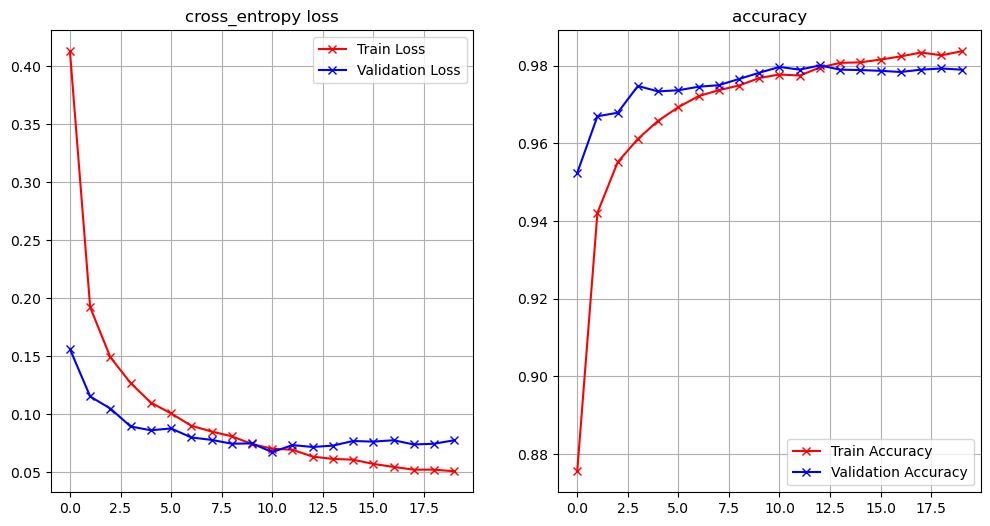

In [8]:
def plot_loss_accuracy(history):
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    plt.show()

# Plot the loss and accuracy curves for the MLP model
plot_loss_accuracy(history_mlp)

## Part-2: CNN
- For the second part, we will use a more complex MLP architecture that is suitable for image processing: Convolutional Neural Networks (CNNs).
- We will use 3D vectors and train various a simple CNN model to compare its results with classic MLP models from Part-1.

In [9]:
# Reshape the data to add a channel dimension (required for CNNs)
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalize pixel values to [0, 1]
X_train_cnn /= 255.0
X_test_cnn /= 255.0

print(f"Train shape: {X_train_cnn.shape}")
print(f"Test shape: {X_test_cnn.shape}")

Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


In [10]:
# Define a CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Ten classes for MNIST digits: 0-9
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(X_test_cnn, y_test),
)

Epoch 1/20
938/938 [==============================] - 31s 32ms/step - loss: 0.2062 - accuracy: 0.9380 - val_loss: 0.0503 - val_accuracy: 0.9842
Epoch 2/20
938/938 [==============================] - 39s 41ms/step - loss: 0.0686 - accuracy: 0.9792 - val_loss: 0.0349 - val_accuracy: 0.9881
Epoch 3/20
938/938 [==============================] - 34s 36ms/step - loss: 0.0500 - accuracy: 0.9847 - val_loss: 0.0388 - val_accuracy: 0.9878
Epoch 4/20
938/938 [==============================] - 33s 35ms/step - loss: 0.0387 - accuracy: 0.9880 - val_loss: 0.0281 - val_accuracy: 0.9915
Epoch 5/20
938/938 [==============================] - 36s 38ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.0290 - val_accuracy: 0.9890
Epoch 6/20
938/938 [==============================] - 35s 38ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0250 - val_accuracy: 0.9916
Epoch 7/20
938/938 [==============================] - 31s 33ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.0246 - val_accuracy:

In [11]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=1)
print("CNN Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 4s 14ms/step - loss: 0.0346 - accuracy: 0.9916
CNN Evaluation:
Test Loss: 0.0346
Test Accuracy: 0.9916


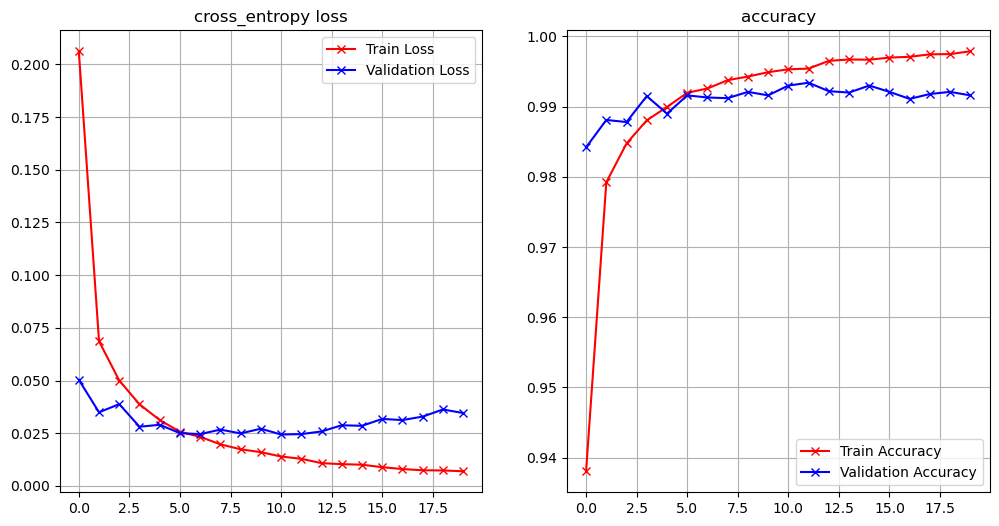

In [12]:
def plot_loss_accuracy(history):
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    plt.show()

# Plot the loss and accuracy curves for the CNN model
plot_loss_accuracy(history_cnn)

# END